In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


from lib.tfno import FNO1d
from lib.utils import relative_l2_error
from lib.dataset import PDEDatasetAll2All

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
DEVICE = "cpu"

In [4]:
modes = 16
width = 64
fno = FNO1d(modes, width).to(DEVICE)  # model
fno.load_state_dict(torch.load("models/tfno_model.pth", weights_only=True))

<All keys matched successfully>

# Evaluating the model for the bonus task 

### Evaluating on test data at different time intervals

In [5]:
dataset_test = PDEDatasetAll2All(
    "data/test_sol.npy",
    device=DEVICE,
    time_pairs=[(0, 1), (0, 2), (0, 3), (0, 4)],
)
test_data_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

In [ ]:
fno.eval()
progress_bar = tqdm.tqdm(test_data_loader)
losses = {}

with torch.no_grad():
    test_relative_l2 = 0.0
    for i, (dt, input, target) in enumerate(progress_bar):
        prediction = fno(input, dt).squeeze(-1)

        loss = relative_l2_error(prediction, target)
        test_relative_l2 += loss.item()
        time_delta = dt.item()

        if time_delta not in losses:
            losses[time_delta] = []
        losses[time_delta].append(loss.item())
        
    test_relative_l2 /= len(test_data_loader)

print(rf"Test relative L2 error (test dataset): {test_relative_l2}")

100%|██████████| 512/512 [00:00<00:00, 547.75it/s]

Test relative L2 error (OOD Dataset): 0.3533451407274697


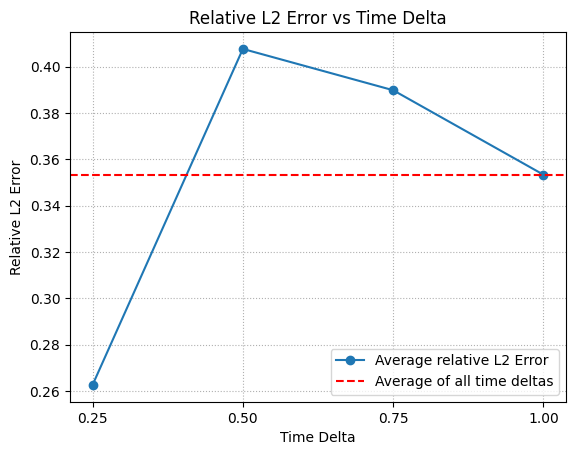

In [7]:
dts = []
means = []
for dt, ls in sorted(losses.items()):
    dts.append(dt)
    means.append(np.mean(ls))

plt.plot(dts, means, marker="o", label="Average relative L2 Error")

# draw horizontal line for average
plt.axhline(y=test_relative_l2, color="r", linestyle="--", label="Average of all time deltas")

plt.xlabel("Time Delta")
plt.xticks(dts)
plt.ylabel("Relative L2 Error")
plt.title("Relative L2 Error vs Time Delta")
plt.grid(True, ls=":")
plt.legend()
plt.show()

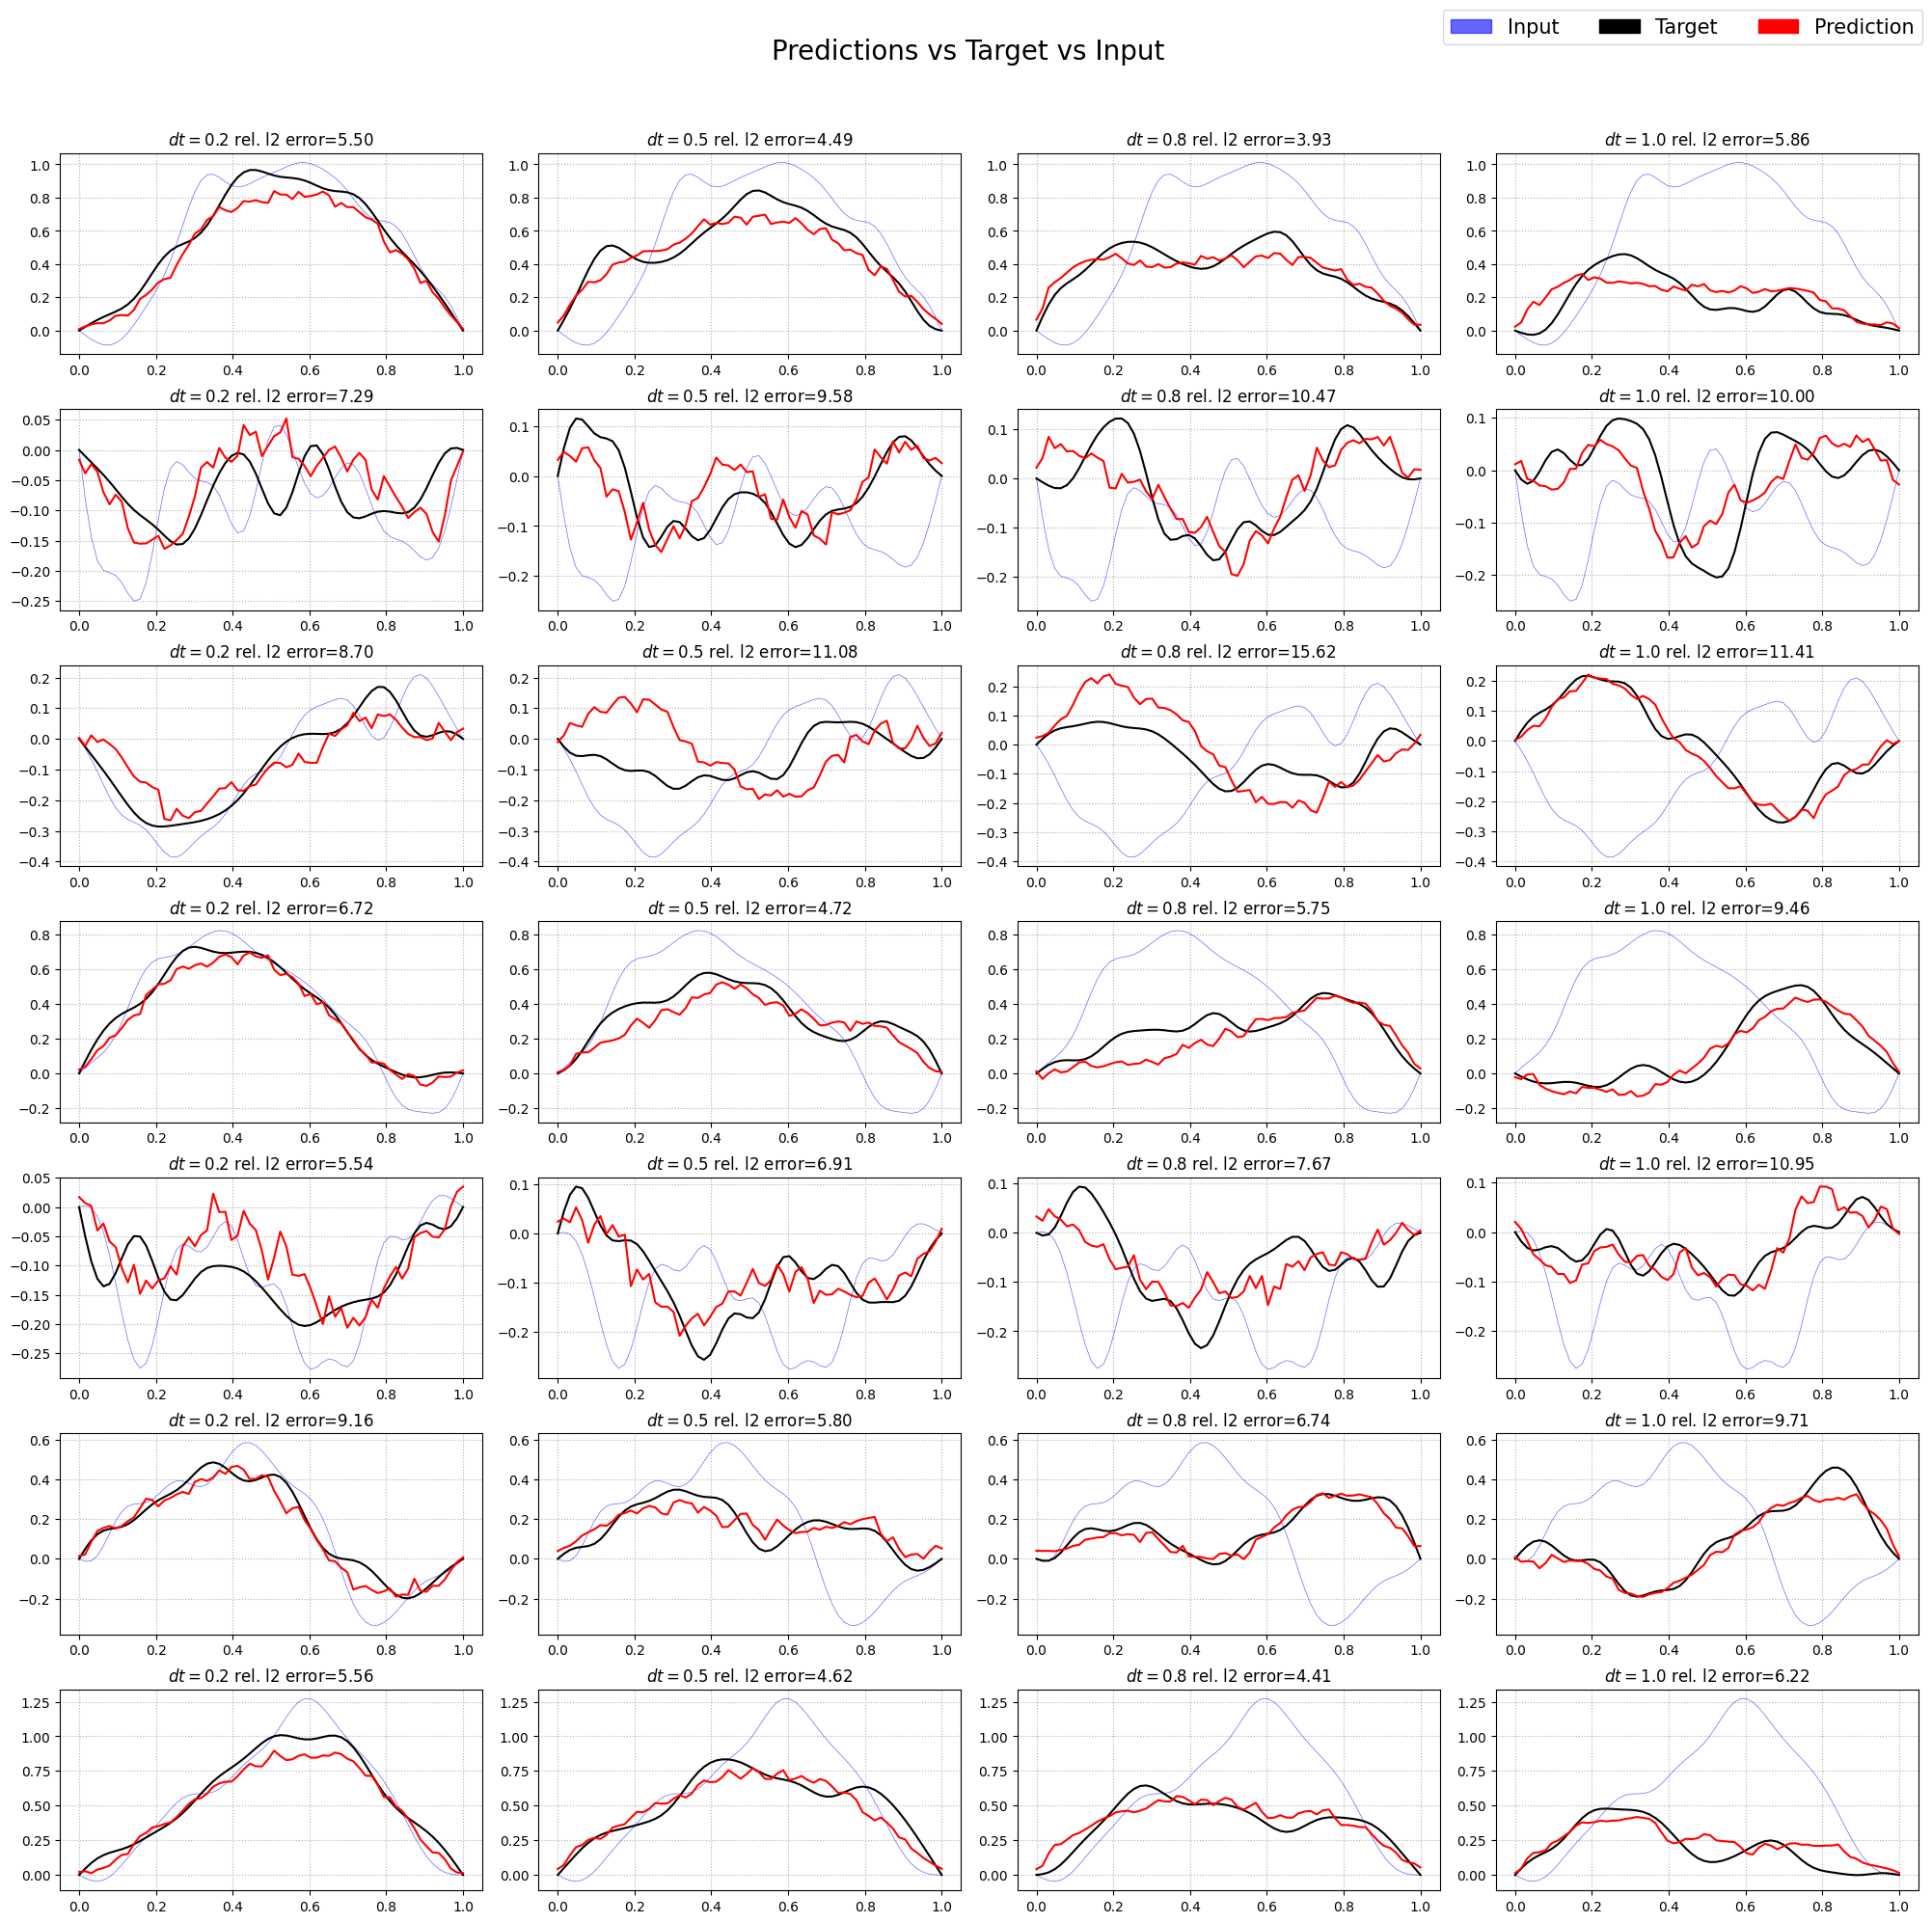

In [8]:
sampler = DataLoader(dataset_test, batch_size=dataset_test.len_times, shuffle=False)

fig, axs = plt.subplots(7, dataset_test.len_times, figsize=(20, 20))

fno.eval()
lines = None
for i, (ax_rows, (time_delta, input, target)) in enumerate(zip(axs, sampler)):
    input_copy = input.clone()

    with torch.no_grad():
        prediction = fno(input, time_delta)

    target = target

    for j, p in enumerate(prediction):
        epsilon = input_copy[j, :, -1][0].item()
        re_l2_error = relative_l2_error(p, target[j])

        ax = ax_rows[j]

        ax.set_title(
            rf"$dt={time_delta[j].item():.1f}$ rel. l2 error=${re_l2_error:.2f}$",
            fontsize=12,
        )

        x_grid = np.linspace(0, 1, 64)

        l1 = ax.plot(
            x_grid,
            input_copy[j, :, 0],
            label="Input",
            alpha=0.6,
            linewidth=0.5,
            color="blue",
        )

        l2 = ax.plot(x_grid, target[j], label="Target", color="black")
        l3 = ax.plot(x_grid, p, label="Prediction", color="red")

        ax.grid(True, which="both", ls=":")

        if i == 0 and j == 0:
            lines = l1 + l2 + l3

labels = [line.get_label() for line in lines]
handles = []
for group_idx in range(len(labels)):
    # Create a simple patch that is the correct colour
    colour = lines[group_idx].get_color()
    opac = lines[group_idx].get_alpha()
    handles.append(Patch(edgecolor=colour, facecolor=colour, fill=True, alpha=opac))
# Acutally create our figure legend, using the handles and labels
fig.legend(
    handles=handles, labels=labels, loc="upper right", ncol=len(labels), fontsize=15
)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Predictions vs Target vs Input", fontsize=20)
plt.show()

### OOD Dataset

In [9]:
dataset_ood = PDEDatasetAll2All("data/test_sol_OOD.npy", device=DEVICE)
ood_data_loader = DataLoader(dataset_ood, batch_size=1, shuffle=True)

In [10]:
fno.eval()
progress_bar = tqdm.tqdm(ood_data_loader)

with torch.no_grad():
    ood_relative_l2 = 0.0
    for i, (dt, input, target) in enumerate(progress_bar):
        prediction = fno(input, dt).squeeze(-1)

        loss = relative_l2_error(prediction, target)
        ood_relative_l2 += loss.item()
    ood_relative_l2 /= len(test_data_loader)

print(rf"Test relative L2 error (OOD Dataset): {ood_relative_l2}")

100%|██████████| 384/384 [00:00<00:00, 508.58it/s]

Test relative L2 error (OOD Dataset): 0.19306313472043257


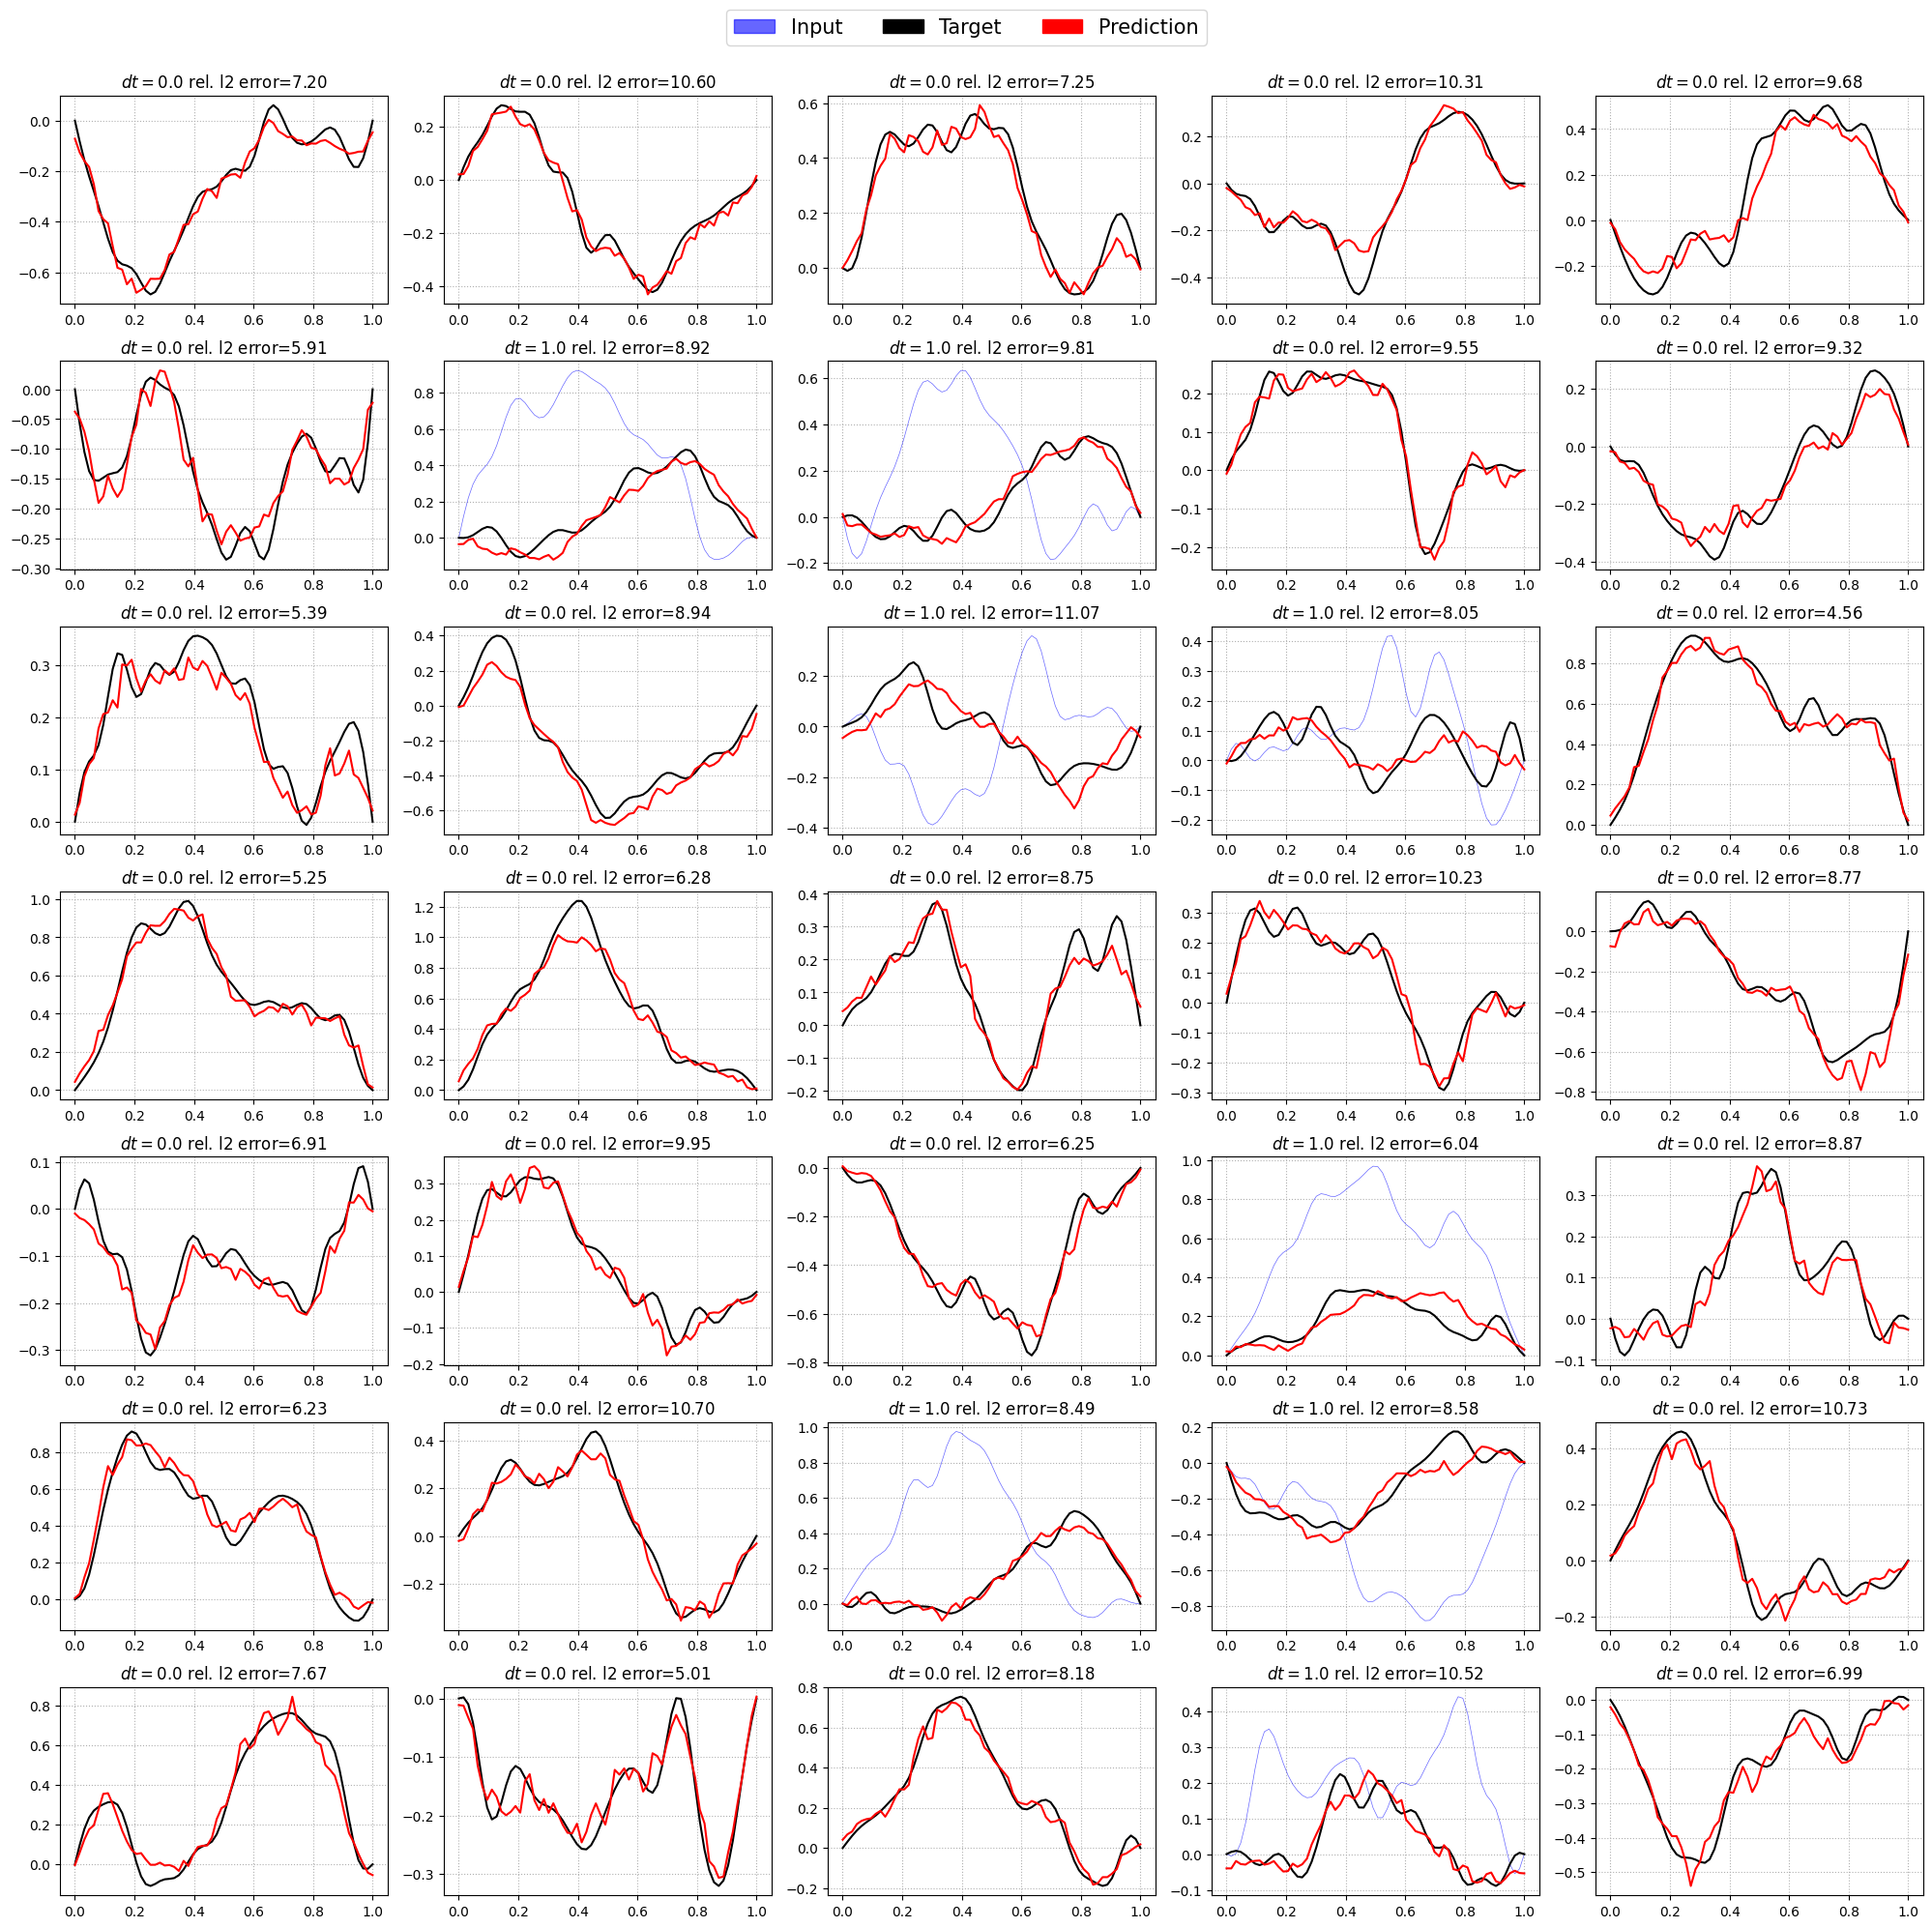

In [11]:
sampler = DataLoader(dataset_ood, batch_size=5, shuffle=True)

fig, axs = plt.subplots(7, 5, figsize=(20, 20))

fno.eval()
lines = None
for i, (ax_rows, (time_delta, input, target)) in enumerate(zip(axs, sampler)):
    input_copy = input.clone()

    with torch.no_grad():
        prediction = fno(input, time_delta)

    target = target

    for j, p in enumerate(prediction):
        epsilon = input_copy[j, :, -1][0].item()
        re_l2_error = relative_l2_error(p, target[j])

        ax = ax_rows[j]

        ax.set_title(
            rf"$dt={time_delta[j].item():.1f}$ rel. l2 error=${re_l2_error:.2f}$",
            fontsize=12,
        )

        x_grid = np.linspace(0, 1, 64)

        l1 = ax.plot(
            x_grid,
            input_copy[j, :, 0],
            label="Input",
            alpha=0.6,
            linewidth=0.5,
            color="blue",
        )

        l2 = ax.plot(x_grid, target[j], label="Target", color="black")
        l3 = ax.plot(x_grid, p, label="Prediction", color="red")

        ax.grid(True, which="both", ls=":")

        if i == 0 and j == 0:
            lines = l1 + l2 + l3

labels = [line.get_label() for line in lines]
handles = []
for group_idx in range(len(labels)):
    # Create a simple patch that is the correct colour
    colour = lines[group_idx].get_color()
    opac = lines[group_idx].get_alpha()
    handles.append(Patch(edgecolor=colour, facecolor=colour, fill=True, alpha=opac))
# Acutally create our figure legend, using the handles and labels
fig.legend(handles=handles, labels=labels, loc="upper center", ncol=len(labels), fontsize=15)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()